# Anime Recommendation System
## Objective

To develop a machine learning-based model that recommends animes to users based on their preferences and viewing history.


## Types of Filtering

### Collaborative Filtering

Collaborative filtering predicts user preferences by analyzing patterns in user behavior. It assumes that users who have agreed on animes in the past will continue to do so in the future.

**Example:**
- User A and User B both liked Movie X and Movie Y. If User A likes Movie Z, User B is likely to enjoy Movie Z as well.

### Content-Based Filtering

Content-based filtering recommends animes by comparing the content of animes that a user has enjoyed in the past with other animes' content. It focuses on the attributes of the animes.

**Example:**
- If a user likes sci-fi animes with a strong female lead, the system will recommend other sci-fi animes with similar characteristics.

## Data Source

Animes dataset from kaggle, which contains user ratings for a wide array of animes.


In [166]:
pip install opendatasets

In [167]:
pip install scikit-surprise

In [168]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database")

Skipping, found downloaded files in "./anime-recommendations-database" (use force=True to force download)


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
!ls anime-recommendations-database

anime.csv  rating.csv


In [171]:
df = pd.read_csv('anime-recommendations-database/anime.csv')
df_rating = pd.read_csv('anime-recommendations-database/rating.csv')

In [172]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [173]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## DATA CLEANING

In [174]:
df_rating = df_rating[df_rating['rating'] != -1]

In [175]:
df_rating.duplicated().sum()

1

In [176]:
df.duplicated().sum()

0

In [177]:
df_rating.isna().sum()

,0
user_id,0
anime_id,0
rating,0


In [178]:
df.replace('Unknown', np.nan, inplace=True)

In [179]:
df.isna().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,340
rating,230
members,0


In [180]:
df.dropna(subset=['genre'], inplace=True)


In [181]:
type_animes_drop = ['Hentai', 'Ecchi', 'Yaoi','Yuri','Shounen Ai','Shoujo Ai','Thriller','Harem']

mask = df['genre'].apply(lambda x: any(genre in x for genre in type_animes_drop))
anime_ids = df.loc[mask, 'anime_id'].tolist()
df = df[~mask].reset_index(drop=True)
df_rating = df_rating[~df_rating['anime_id'].isin(anime_ids)].reset_index(drop=True)

In [182]:
rating_counts = df_rating['user_id'].value_counts()

In [183]:
df_rating['user_id'].value_counts()

,count
user_id,
42635,3011
51693,2381
57620,2236
59643,2174
12431,2116
...,...
46944,1
46888,1
46847,1


In [184]:
df.describe(include=[object])

,name,genre,type,episodes
count,10086,10086,10067,9812
unique,10084,2556,6,185
top,Saru Kani Gassen,Comedy,TV,1
freq,2,523,3360,4998


In [185]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861027 entries, 0 to 4861026
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 111.3 MB


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10086 non-null  int64  
 1   name      10086 non-null  object 
 2   genre     10086 non-null  object 
 3   type      10067 non-null  object 
 4   episodes  9812 non-null   object 
 5   rating    9897 non-null   float64
 6   members   10086 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 551.7+ KB


In [187]:
total_users = len(np.unique(df_rating["user_id"]))
print("The count of unique userID in the dataset is : ", total_users)

The count of unique userID in the dataset is :  68516


In [188]:
max_id_user = np.max(df_rating["user_id"])
min_id_user = np.min(df_rating["user_id"])
print("The maximum user ID is : ", max_id_user)
print("The minimum user ID is : ", min_id_user)

The maximum user ID is :  73516
The minimum user ID is :  1


In [189]:
rating_counts = df_rating['rating'].value_counts().sort_index()

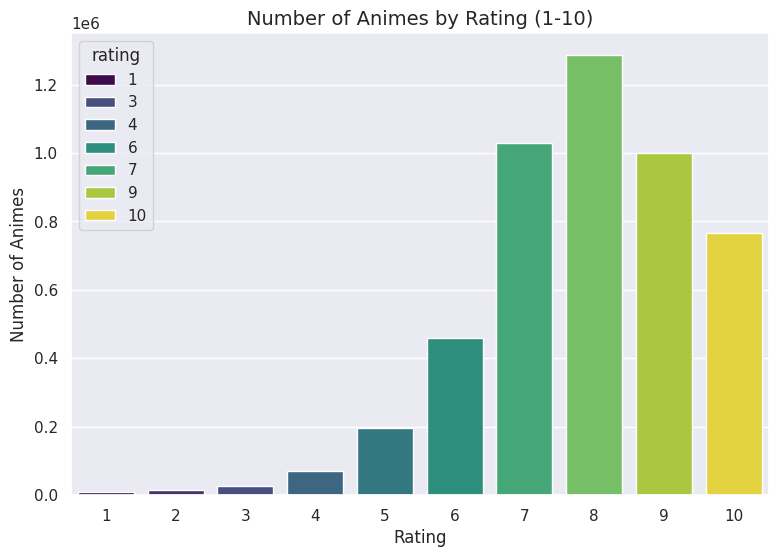

In [190]:
plt.figure(figsize=(9, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values,hue=rating_counts.index, palette='viridis')


plt.title('Number of Animes by Rating (1-10)', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Animes', fontsize=12)

plt.show()

In [191]:
anime_rating_counts = df_rating['anime_id'].value_counts().sort_index()

In [192]:
anime_rating_counts

,count
anime_id,
1,13449
5,5790
6,9385
7,2169
8,308
...,...
34324,11
34325,15
34349,3


In [193]:
top_10_anime = anime_rating_counts.head(10)
top_10_anime_info = df[df['anime_id'].isin(top_10_anime.index)]
top_10_anime_info.loc[:, 'rating_count']= top_10_anime.values

top_10_anime_info

<ipython-input-193-11666fd00a68>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_anime_info.loc[:, 'rating_count']= top_10_anime.values


,anime_id,name,genre,type,episodes,rating,members,rating_count
21,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,13449
133,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636,5790
191,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069,9385
234,18,Initial D Fourth Stage,"Action, Cars, Drama, Seinen, Sports",TV,24,8.24,41584,2169
293,16,Hachimitsu to Clover,"Comedy, Drama, Josei, Romance",TV,24,8.18,130646,308
390,15,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV,145,8.08,83648,2002
759,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,3291
879,17,Hungry Heart: Wild Striker,"Comedy, Shounen, Slice of Life, Sports",TV,52,7.74,13469,528
1874,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905,1510
2788,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848,22071


the data too big for sparse matrix so we are about to eliminate some animes and some user

In [194]:
all_genres = df['genre'].str.split(', ', expand=True).stack()
genre_counts = all_genres.value_counts()

In [195]:
genre_counts_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})
genre_counts_df['Rating'] = 0

In [196]:
for genre in genre_counts_df['Genre']:
    n_anime =0
    for i in range(df.shape[0]):
        if genre in df.iloc[i].genre:
            df_anime_rating = df_rating[df_rating['anime_id'] == df.iloc[i].anime_id]
            if(df_anime_rating.shape[0] == 0):
              continue
            genre_counts_df.loc[genre_counts_df['Genre'] == genre, 'Rating'] += df_anime_rating['rating'].mean()
            n_anime += 1
    genre_counts_df.loc[genre_counts_df['Genre'] == genre, 'Rating'] /= n_anime

<ipython-input-196-7e419194db13>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[9.44949495]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  genre_counts_df.loc[genre_counts_df['Genre'] == genre, 'Rating'] += df_anime_rating['rating'].mean()


In [197]:
genre_counts_df

,Genre,Count,Rating
0,Comedy,3961,6.913193
1,Action,2551,6.990239
2,Adventure,2246,6.969193
3,Fantasy,2084,6.894226
4,Sci-Fi,1875,6.878029
5,Drama,1808,7.201768
6,Kids,1586,6.242802
7,Shounen,1557,7.255770
8,Slice of Life,1140,6.994638
9,Romance,1000,7.210334


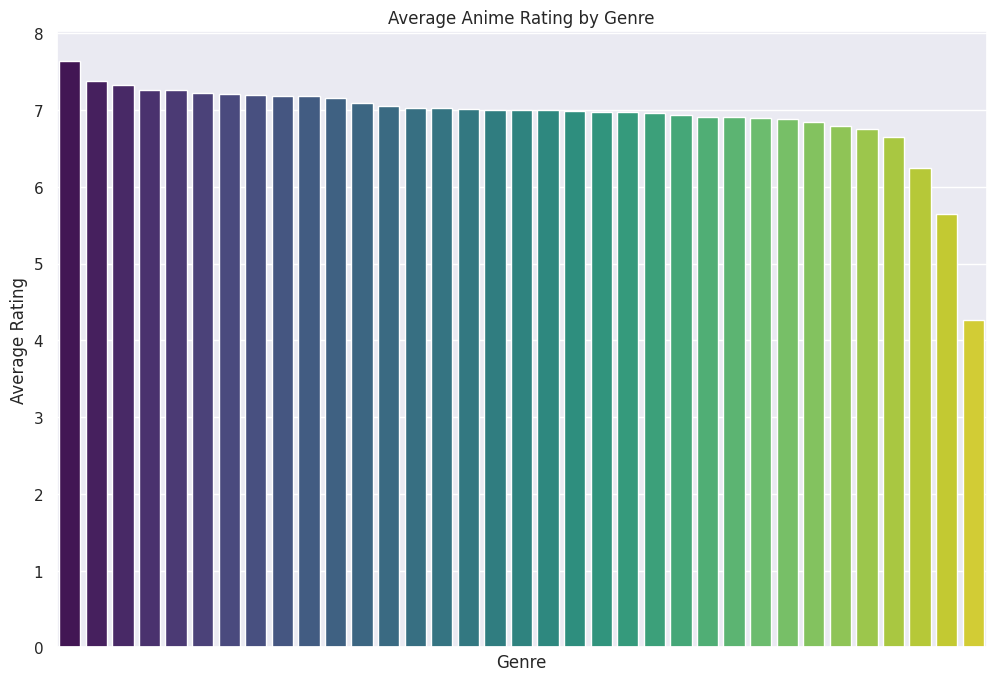

In [198]:
plt.figure(figsize=(12, 8))
genre_counts_df.sort_values(by='Rating', ascending=False, inplace=True)
sns.barplot(x='Genre', y='Rating', data=genre_counts_df,hue='Genre', palette='viridis',legend=False)
plt.title('Average Anime Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks([])
plt.show()

# Get Feature Selection
## Defining Target Variable (y) and Feature Variables (X)

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix, find

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline

from surprise import SVD
from surprise.model_selection import GridSearchCV

In [200]:
import difflib
from datetime import datetime
import random

In [201]:
df.drop(['rating','members','episodes'],axis = 1, inplace = True)

In [202]:
df_rating = pd.merge(df, df_rating, on='anime_id')

In [203]:
random_users_train = np.random.choice(df_rating['user_id'].unique(), size=1000, replace=False)
random_animes_train = np.random.choice(df_rating['name'].unique(), size=5000, replace=False)



In [204]:
df_filtered = df_rating[(df_rating['user_id'].isin(random_users_train)) & (df_rating['name'].isin(random_animes_train))]

In [205]:
df_filtered

,anime_id,name,genre,type,user_id,rating
2100,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,420,7
2115,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,463,10
2198,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,690,10
2203,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,697,9
2782,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,2530,10
...,...,...,...,...,...,...
4860344,7713,Nihon Mukashibanashi: Saru Kani,Fantasy,Movie,10795,7
4860497,23739,Peter Pan no Bouken Specials,"Adventure, Fantasy",Special,13084,4
4860617,7980,Shin Obake no Q-tarou,"Comedy, School, Slice of Life, Supernatural",TV,26638,8
4860844,9228,Wan Wan Chuushingura,"Action, Adventure, Drama, Fantasy",Movie,22681,6


In [206]:
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Data Modeling

### USER - ITEM SPARSE MATRIX

In [207]:
sparse_matrixUI_train = csr_matrix((train_df['rating'], (train_df['user_id'], train_df['anime_id'])))

In [208]:
print(sparse_matrixUI_train[:5, :5].toarray())

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [209]:
rows, cols = sparse_matrixUI_train.shape

In [210]:
presentElements = sparse_matrixUI_train.count_nonzero()
print("No. of ratings in the train matrix is : ", presentElements)
print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

No. of ratings in the train matrix is :  33160
Sparsity Of Train matrix : 99.99868210380585% 


In [211]:
sparse_matrixUI_test = csr_matrix((test_df['rating'], (test_df['user_id'], test_df['anime_id'])))
rows_test, cols_test = sparse_matrixUI_test.shape
presentElements_test = sparse_matrixUI_test.count_nonzero()
rows_test, cols_test

(73174, 34241)

In [212]:
print("Sparsity Of Test matrix: {}% ".format((1-(presentElements_test/(rows_test*cols_test)))*100))

Sparsity Of Test matrix: 99.99966913464469% 


In [213]:
presentElements_test

8290

Observations:

1. Shape of sparse matrix depends on highest value of userId and highest value of AnimeId.
2. In the test set, there are few users from train set which is not present in the test set.
3. For the AnimeId, there are less Animes in the train set as compared to test set. The reason stems from the fact that we split the data based on time, and newer animes would have fallen into test set.
4. The sparsity of train set and test set are 99.99%.

In [214]:
def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}

    return averageRatings

In [215]:
AvgRatingUser = getAverageRatings(sparse_matrixUI_train, True)
AvgRatingAnime = getAverageRatings(sparse_matrixUI_train, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users

print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users :  68516
No. of Users in Train data :  962
No. of Users not present in Train data : 67554(99.0%)


In [216]:
train_animes = len(AvgRatingAnime)
total_animes = len(np.unique(train_df["anime_id"]))
uncommonAnimes = total_animes - train_animes

print("Total no. of Animes : ", total_animes)
print("No. of Animes in Train data : ", train_animes)
print("No. of Animes not present in Train data = {}({}%)".format(uncommonAnimes, np.round((uncommonAnimes/total_animes)*100), 2))

Total no. of Animes :  2459
No. of Animes in Train data :  2459
No. of Animes not present in Train data = 0(0.0%)


In [217]:
AvgRatingUser_test = getAverageRatings(sparse_matrixUI_test, True)
AvgRatingAnime_test = getAverageRatings(sparse_matrixUI_test, False)
test_users = len(AvgRatingUser_test)
uncommonUsers_test = total_users - test_users

print("Total no. of Users : ", total_users)
print("No. of Users in Test data : ", test_users)
print("No. of Users not present in Test data : {}({}%)".format(uncommonUsers_test, np.round((uncommonUsers_test/total_users)*100), 2))

Total no. of Users :  68516
No. of Users in Test data :  829
No. of Users not present in Test data : 67687(99.0%)


1. Recommendation System suffers from Cold Start problems, which needs to be tackled wisely in order to design a effective system.
2. There are 171, 1.0% of the users are not present in the training data.
3. There are 0, 0% of the animes which are not present in the training data.

### Creating Similarity Matrix
##### 1.Computing Item-Item Similarity Matrix


In [218]:
m_m_similarity = cosine_similarity(sparse_matrixUI_train.T, dense_output = False)


In [219]:
anime_list_train = train_df['name'].tolist()

Use difflib to correct anime name and Get top-n similar animes

In [220]:
def GetSimilarAnimesUsingAnimeAnimeSimilarity(anime_name, num_of_similar_animes):
    matches = difflib.get_close_matches(anime_name, anime_list_train)
    if len(matches) == 0:
        return "No Match Found"
    close_match=matches[0]
    anime_row = train_df[train_df["name"] == close_match]
    anime_id = anime_row.iloc[0]["anime_id"]
    similar_anime_id_list = np.argsort(-m_m_similarity[anime_id].toarray().ravel())[0:num_of_similar_animes+1]
    sm_df = train_df[train_df["anime_id"].isin(similar_anime_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_anime_id_list).index(x["anime_id"]), axis=1)
    sm_df = sm_df.drop_duplicates(subset=["anime_id"])
    sm_df = sm_df.drop(columns=["user_id", "rating", "episode"], errors="ignore")

    return sm_df.sort_values("order")

In [221]:
GetSimilarAnimesUsingAnimeAnimeSimilarity("Naruto", 10)

<ipython-input-220-f6429447ca19>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_df["order"] = sm_df.apply(lambda x: list(similar_anime_id_list).index(x["anime_id"]), axis=1)


,anime_id,name,genre,type,order
2344146,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,0
9405,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,1
1942792,9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,2
871649,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,3
1514968,3588,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,4
895306,813,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,5
762380,6746,Durarara!!,"Action, Mystery, Supernatural",TV,6
2269897,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,7
31817,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,8
4585759,225,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV,9


##### 2. Computing Item-Item Similarity Matrix

In [222]:
row_index, col_index = sparse_matrixUI_train.nonzero()
unique_user_id = np.unique(row_index)
print("Max User id is :", np.max(unique_user_id))

Max User id is : 73482


In [223]:
def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):

    if user_id in unique_user_id:
        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        top_similar_user_ids = sim.argsort()[::-1]
        top_similarity_values = sim[top_similar_user_ids]

    return top_similar_user_ids[1: num_of_similar_users+1]

In [224]:
globalAvgRating = np.round((sparse_matrixUI_train.sum()/sparse_matrixUI_train.count_nonzero()), 2)
print("Global average of all animes ratings in Train Set is : ", globalAvgRating)

Global average of all animes ratings in Train Set is :  7.9


In [225]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):

    startTime = datetime.now()

    # Extracting userId list, animeId list and Ratings
    sample_users, sample_animes, sample_ratings = find(SampledSparseData)

    print("No. of rows in the returned dataset : ", len(sample_ratings))

    count = 0
    data = []

    for user, anime, rating in zip(sample_users, sample_animes, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "anime Id" average & global average rating-----------#
        row.append(user)
        row.append(anime)
        row.append(globalAvgRating)

#----------------------------------Appending "user" average, "anime" average & rating of "user""anime"-----------#
        try:
            row.append(AvgRatingUser[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:
            row.append(AvgRatingAnime[anime])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "anime" by top 5 similar users with "user"--------------------#
        try:
            user_vector = TrainSampledSparseData[user, :].toarray()
            similar_users = cosine_similarity(user_vector, TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, anime].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([AvgRatingAnime[anime]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "anime" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "anime" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new anime#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar animes with "anime"------------------#
        try:
            similar_animes = cosine_similarity(TrainSampledSparseData[:,anime].T, TrainSampledSparseData.T).ravel()
            similar_animes_indices = np.argsort(-similar_animes)[1:]
            similar_animes_ratings = TrainSampledSparseData[user, similar_animes_indices].toarray().ravel()
            top_similar_anime_ratings = list(similar_animes_ratings[similar_animes_ratings != 0][:5])
            top_similar_anime_ratings.extend([AvgRatingUser[user]]*(5-len(top_similar_anime_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_anime_ratings)
        ########Cold Start Problem, for a new user or a new anime#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Appending rating of "user""anime"-----------#
        row.append(rating)

        count += 1

        data.append(row)

        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

In [226]:
data_rows = CreateFeaturesForTrainData(sparse_matrixUI_train, sparse_matrixUI_train)

No. of rows in the returned dataset :  33160
Done for 5000. Time elapsed: 0:00:41.405947
Done for 10000. Time elapsed: 0:01:22.596629
Done for 15000. Time elapsed: 0:02:03.206710
Done for 20000. Time elapsed: 0:02:44.358251
Done for 25000. Time elapsed: 0:03:24.797717
Done for 30000. Time elapsed: 0:04:06.515717
Total Time for 33160 rows = 0:04:32.352065
Completed..


In [227]:
test_data_rows = CreateFeaturesForTrainData(sparse_matrixUI_test, sparse_matrixUI_train)

No. of rows in the returned dataset :  8290
Done for 5000. Time elapsed: 0:00:41.421348
Total Time for 8290 rows = 0:01:08.271842
Completed..


In [228]:
names = ["User_ID", "Anime_ID", "Global_Average", "User_Average", "Anime_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [229]:
print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

The shape of the dataframe is :  (33160, 16)
Number of missing Values :  0


,User_ID,Anime_ID,Global_Average,User_Average,Anime_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,125,20,7.9,7.222222,7.746479,8.0,7.0,8.0,6.0,9.0,8.0,7.0,9.0,6.0,4.0,4
1,125,30,7.9,7.222222,8.352941,10.0,9.0,9.0,9.0,7.0,7.0,8.0,9.0,9.0,4.0,4
2,125,33,7.9,7.222222,8.617647,8.0,9.0,9.0,7.0,9.0,4.0,9.0,4.0,9.0,7.0,6
3,125,44,7.9,7.222222,8.750000,8.0,10.0,8.0,9.0,8.0,7.0,4.0,9.0,9.0,9.0,10
4,125,226,7.9,7.222222,8.169173,10.0,9.0,9.0,7.0,10.0,8.0,4.0,9.0,4.0,9.0,7


In [230]:
print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (8290, 16)
Number of missing Values :  0


,User_ID,Anime_ID,Global_Average,User_Average,Anime_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,125,10800,7.9,7.222222,8.576923,8.0,9.0,8.0,8.0,7.0,9.0,8.0,7.0,4.0,7.0,9
1,420,121,7.9,7.078947,8.558704,10.0,7.0,10.0,9.0,8.0,6.0,7.0,7.0,9.0,7.0,7
2,420,550,7.9,7.078947,7.062500,6.0,6.0,9.0,8.0,6.0,8.0,6.0,7.0,9.0,7.0,7
3,420,2581,7.9,7.078947,8.347826,8.0,9.0,8.0,5.0,7.0,9.0,8.0,7.0,9.0,9.0,9
4,420,3972,7.9,7.078947,7.923077,7.0,7.0,9.0,9.0,8.0,4.0,9.0,6.0,7.0,7.0,9


Observations:

The description of the features are stated below:
1. User_ID: ID of a this User
2. Anime_ID: ID of a this anime
3. Global_Average: Global Average Rating
4. User_Average: Average Rating of this User
5. Anime_Average: Average Rating of this anime
6. Ratings given to this Anime by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)
11. Ratings given by this User to top 5 similar Animes with this Anime: (SMR1, SMR2, SMR3, SMR4, SMR5)
16. Rating: Rating given by this User to this Amine


**Transforming Data for Surprise Models**

Transforming Train Data:

We can't give raw data (anime, user, rating) to train the model in Surprise library. They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNN, BaseLineOnly, etc.., in Surprise.

We can form the trainset from a file, or from a Pandas DataFrame. http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

Transforming Test Data:

For test data we just have to define a tuple (user, item, rating).
Check out this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812

Above link is a github of surprise library. Check methods "def all_ratings(self)" and "def build_testset(self)" from line 177 to 201(If they modify the file then line number may differ, but you can always check aforementioned two methods).
"def build_testset(self)" method returns a list of tuples of (user, item, rating).


In [231]:
train_regression_data[['User_ID', 'Anime_ID', 'Rating']].head(5)

,User_ID,Anime_ID,Rating
0,125,20,4
1,125,30,4
2,125,33,6
3,125,44,10
4,125,226,7


In [232]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_regression_data[["User_ID", "Anime_ID", "Rating"]], reader)
trainset = data.build_full_trainset()

In [233]:
testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Anime_ID"].values, test_regression_data["Rating"].values))

## Model Buliding

We will try to build a regression model to predict the rating given by an user to a anime based on the generated fetures.

We have two Error Metrics:

  - RMSE: Root Mean Square Error: RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.

  - MAPE: Mean Absolute Percentage Error: The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.

    The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

    where At is the actual value and Ft is the forecast value.


In [234]:
# Utilities to save the modelling results

error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

In [235]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = pd.concat([error_table, pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns=error_cols)], ignore_index=True)
    error_table.reset_index(drop = True, inplace = True)


    # Function to calulate RMSE and MAPE values
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [236]:
# Apply Xgboost Regressor on the Train and Test Data

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):

    startTime = datetime.now()
    train_result = dict()
    test_result = dict()

    clf = xgb.XGBRegressor(n_estimators = 100, verbosity=1, n_jobs  = 10)
    clf.fit(x_train, y_train)
    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}

    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}

    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)

    plot_importance(xgb, clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)

    return train_result, test_result

# Function to plot feature importance for a model

def plot_importance(model, clf):

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])

    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

In [237]:
# in surprise prediction of every data point is returned as dictionary like this:
# "user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
# In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [238]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name):

    startTime = datetime.now()

    train = dict()
    test = dict()

    algo.fit(trainset)

#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}

#-----------------Evaluating Test Data------------------#
    print("-"*50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-"*50)
    print("Time Taken = "+str(datetime.now() - startTime))

    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)

    return train, test

In [239]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

--------------------------------------------------
TRAIN DATA
RMSE : 0.9116608785193308
MAPE : 9.924355891511674
--------------------------------------------------
TEST DATA
RMSE : 1.263633432643752
MAPE : 14.603603273110583
--------------------------------------------------
Time Taken :  0:00:00.273072


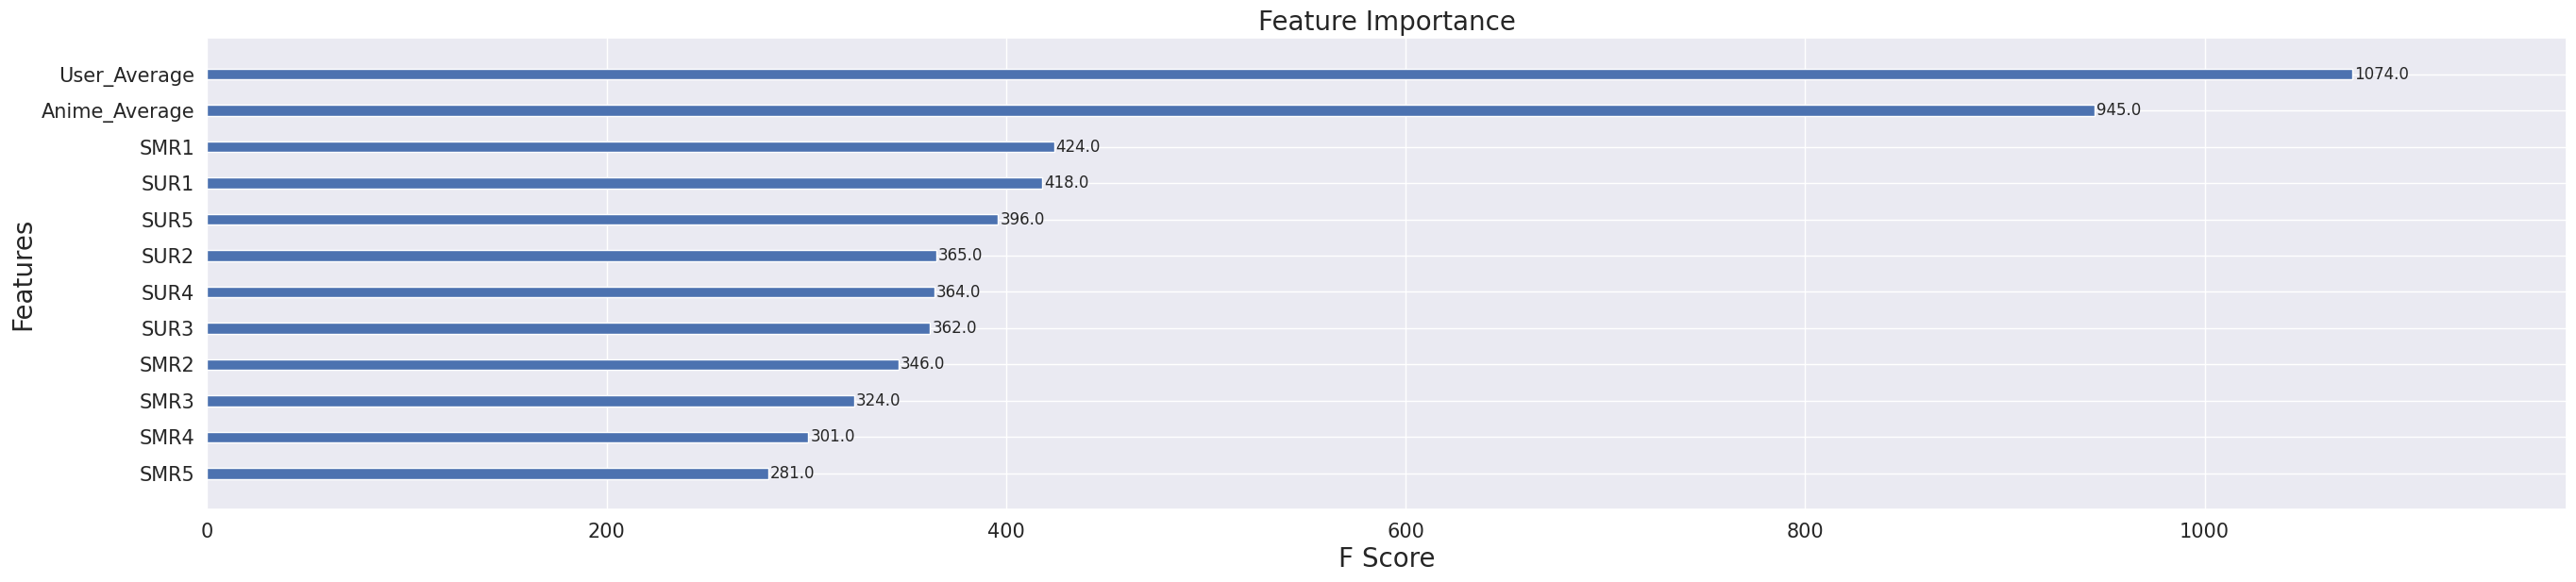

<ipython-input-235-0ecda92f00ec>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_table = pd.concat([error_table, pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns=error_cols)], ignore_index=True)


In [240]:
# Training the Xgboost Regression Model on with the 13 features

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

In [241]:
# Applying BaselineOnly from the surprise library to predict the ratings

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 3.274316619373737
MAPE = 36.40944095472067
--------------------------------------------------
TEST DATA
RMSE = 3.2693282111878577
MAPE = 36.51963382727183
--------------------------------------------------
Time Taken = 0:00:00.199977


In [242]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
test_regression_data["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

--------------------------------------------------
TRAIN DATA
RMSE : 0.9109403646172161
MAPE : 9.93717815192015
--------------------------------------------------
TEST DATA
RMSE : 1.2756251167772044
MAPE : 14.733986526735096
--------------------------------------------------
Time Taken :  0:00:00.280722


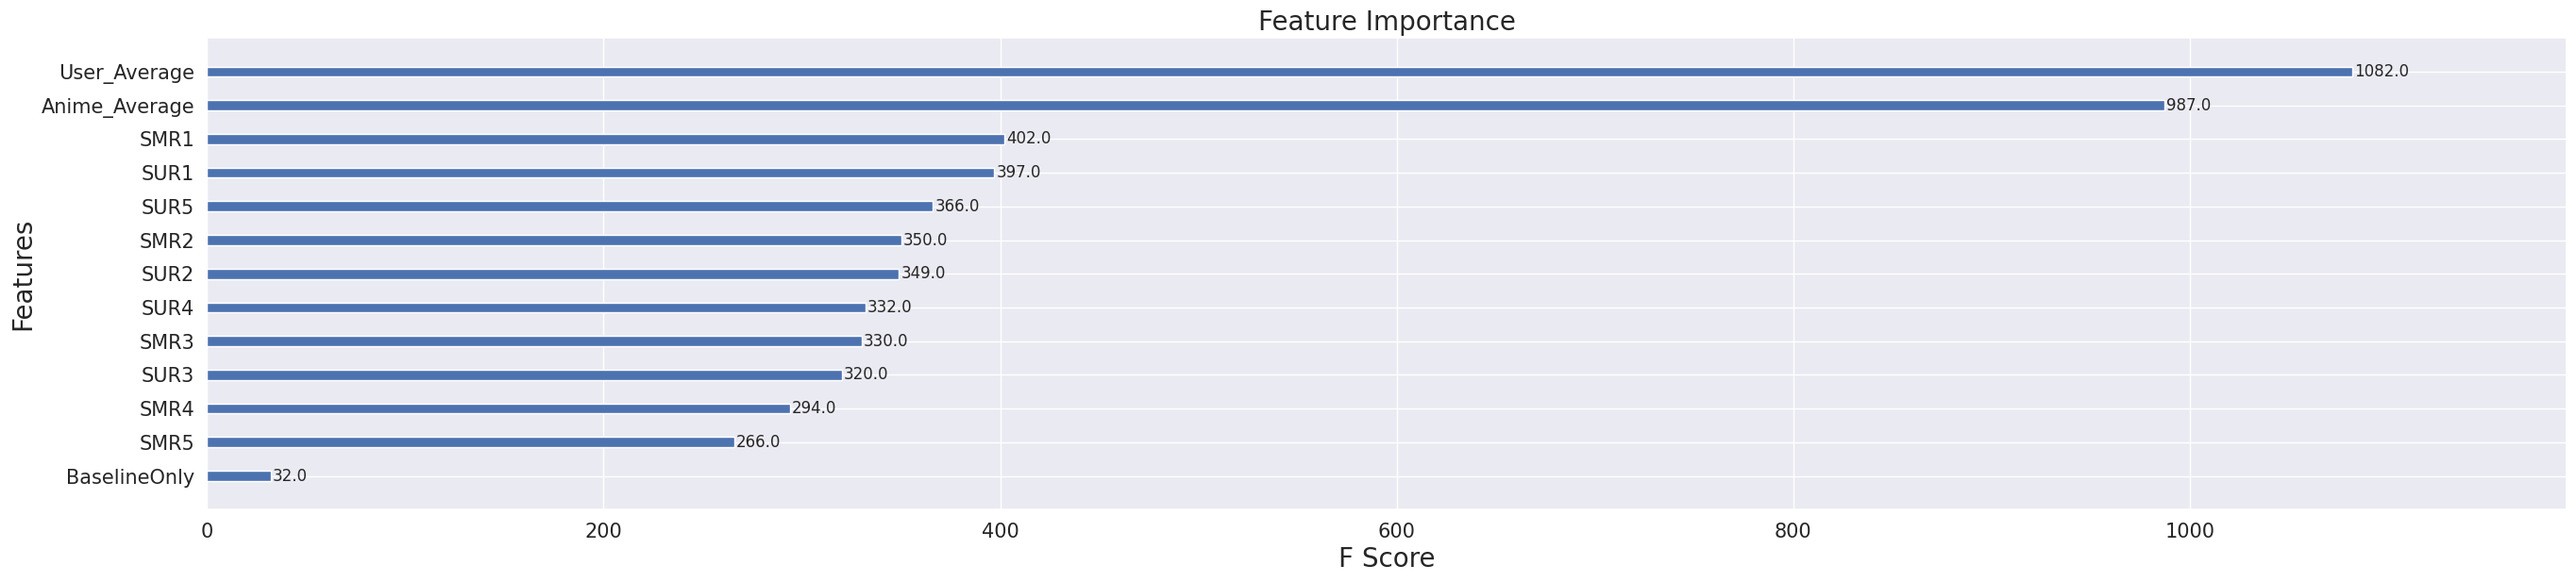

In [243]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

In [244]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [245]:
# Applying the KNN-Baseline with the searched parameters

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 3.2638180472077956
MAPE = 35.251785324174286
--------------------------------------------------
TEST DATA
RMSE = 3.273491215779323
MAPE = 36.64264457041331
--------------------------------------------------
Time Taken = 0:00:02.238185


In [246]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [247]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 3.2645839063143876
MAPE = 35.351371810649
--------------------------------------------------
TEST DATA
RMSE = 3.269159962219056
MAPE = 36.47845373227295
--------------------------------------------------
Time Taken = 0:00:03.327758


In [248]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_regression_data["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_regression_data["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

--------------------------------------------------
TRAIN DATA
RMSE : 0.8563529196373093
MAPE : 8.795909755703846
--------------------------------------------------
TEST DATA
RMSE : 1.2600804608252605
MAPE : 14.793544194490943
--------------------------------------------------
Time Taken :  0:00:00.334041


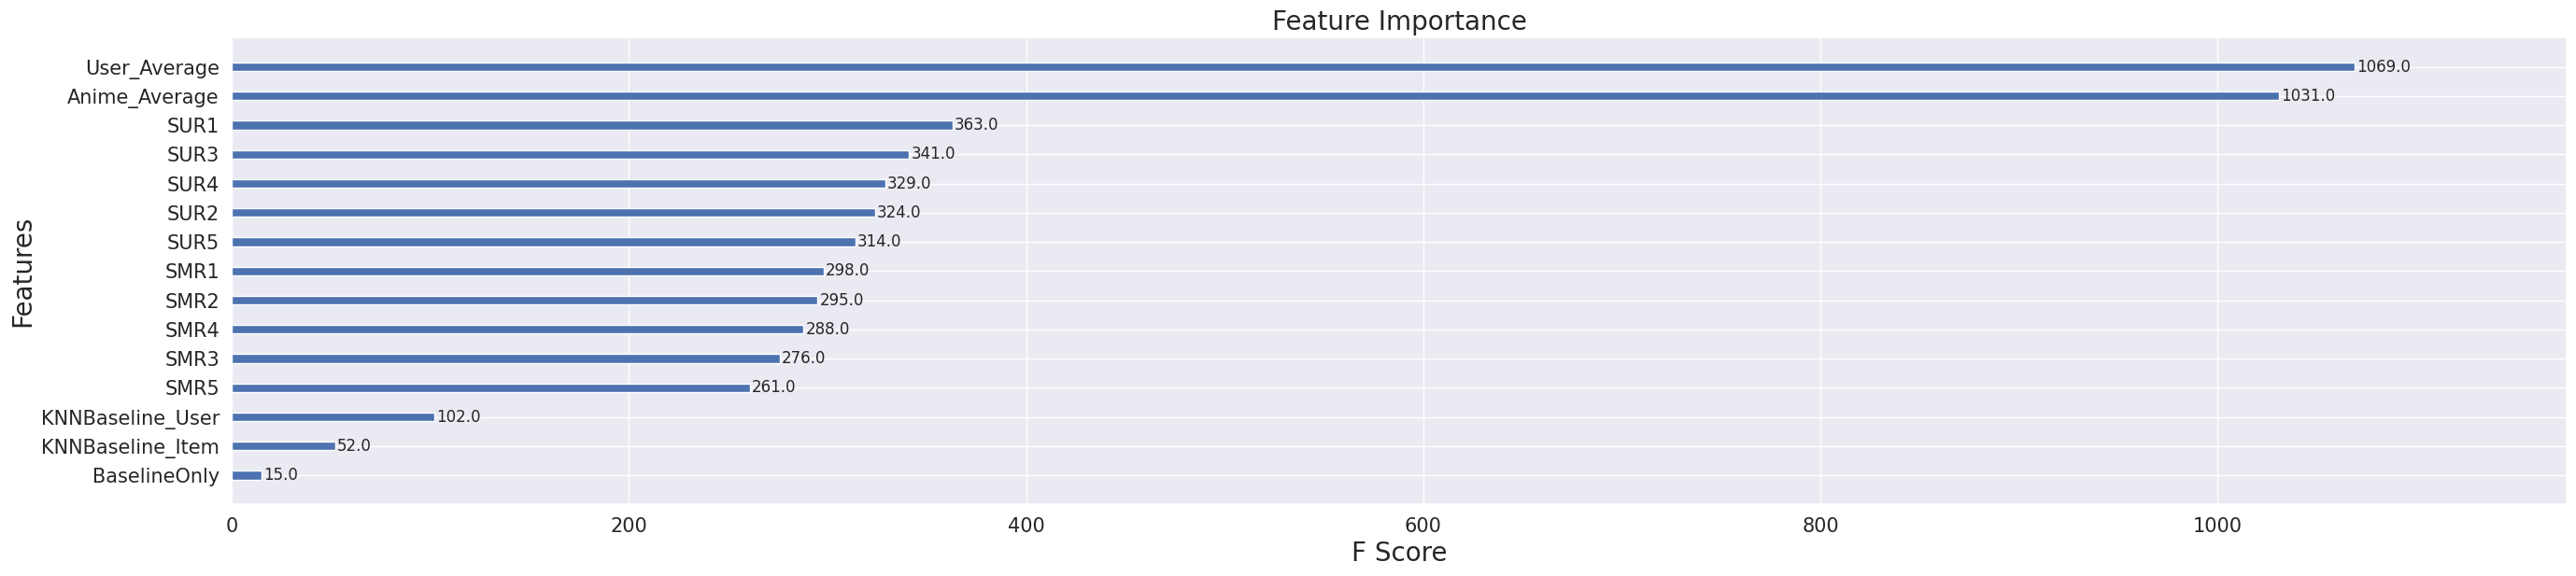

In [249]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE : 0.8563529196373093
MAPE : 8.795909755703846
--------------------------------------------------
TEST DATA
RMSE : 1.2600804608252605
MAPE : 14.793544194490943
--------------------------------------------------
Time Taken :  0:00:00.355131


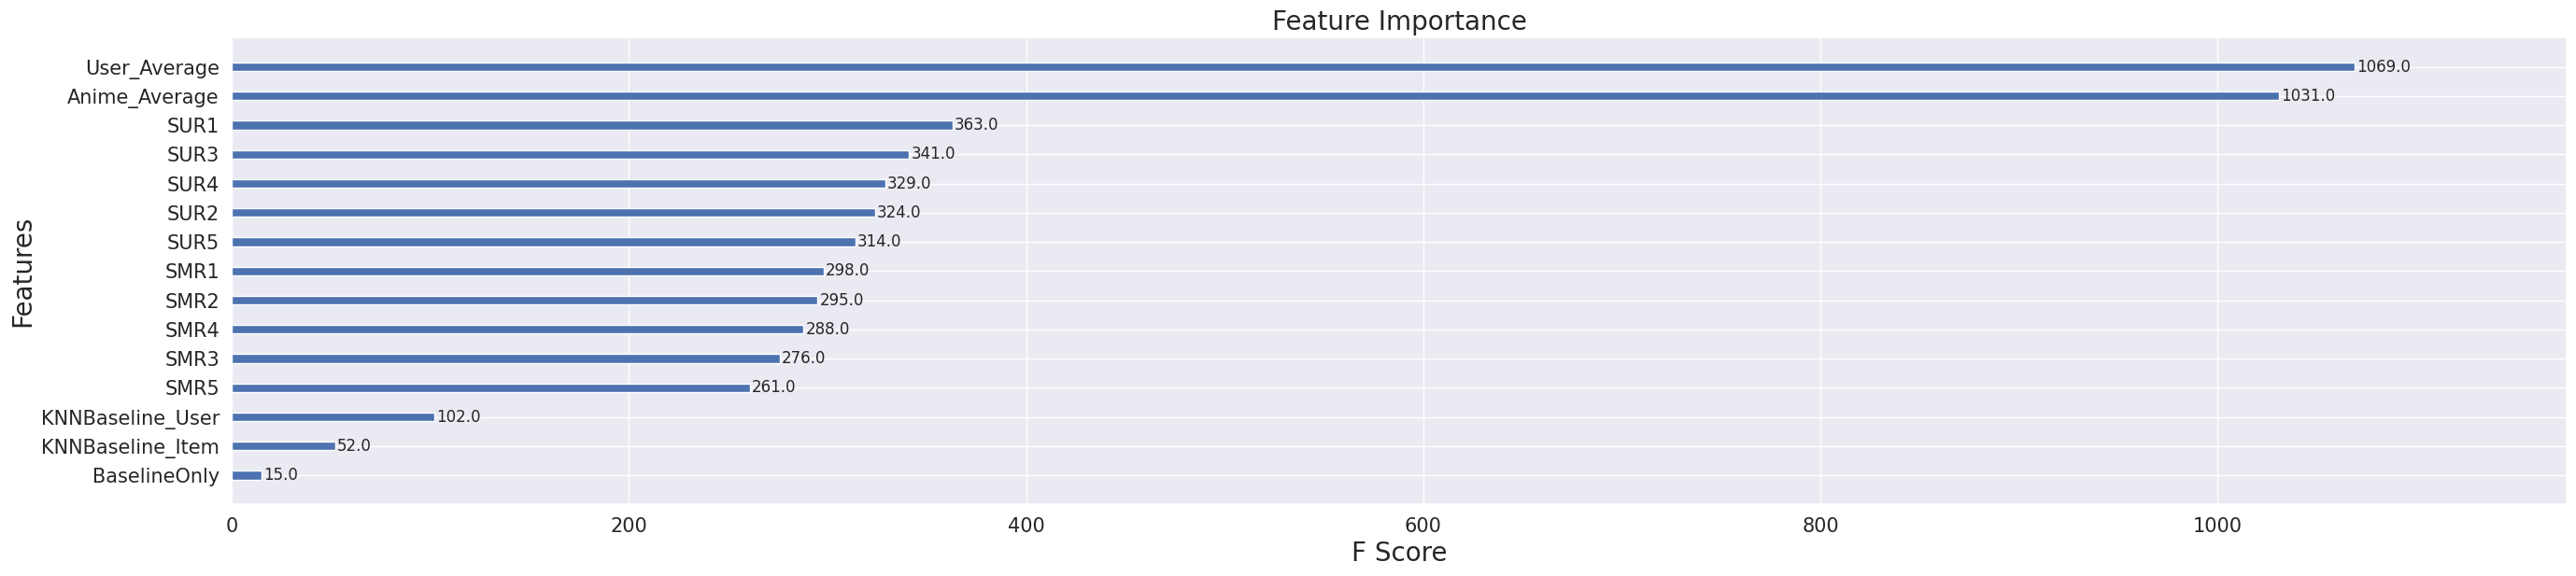

In [250]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

In [251]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [252]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 3.263424014965533
MAPE = 35.19723746523773
--------------------------------------------------
TEST DATA
RMSE = 3.2691079151791262
MAPE = 36.47528846669058
--------------------------------------------------
Time Taken = 0:00:02.573660


In [253]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]


test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]


--------------------------------------------------
TRAIN DATA
RMSE : 0.8563529196373093
MAPE : 8.795909755703846
--------------------------------------------------
TEST DATA
RMSE : 1.2600804608252605
MAPE : 14.793544194490943
--------------------------------------------------
Time Taken :  0:00:00.332802


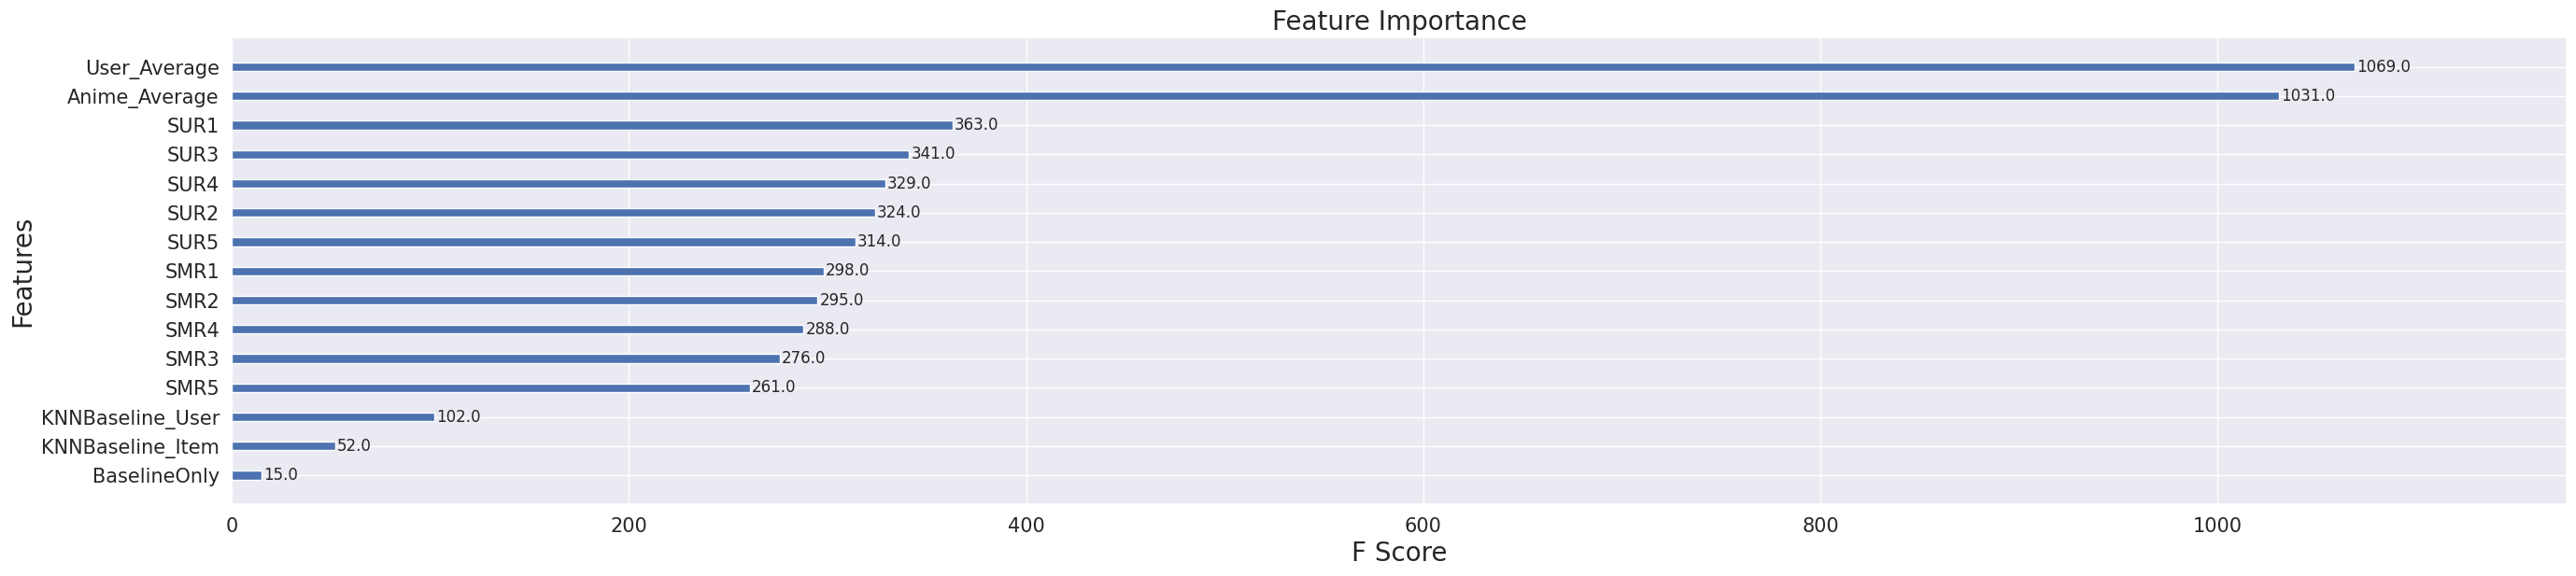

In [254]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

In [255]:
# Matrix Factorization using SVD from Surprise Library

# here, n_factors is the equivalent to dimension 'd' when matrix 'A'
# is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

3.2750757454442065
{'n_factors': 5}


In [256]:
#Applying SVD with best parameters

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 3.2746562107084354
MAPE = 36.476065239604964
--------------------------------------------------
TEST DATA
RMSE = 3.2696346875977036
MAPE = 36.59615503953208
--------------------------------------------------
Time Taken = 0:00:00.266960


In [257]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD

train_regression_data["SVD"] = model_train_evaluation["SVD"]["Prediction"]
test_regression_data["SVD"] = model_test_evaluation["SVD"]["Prediction"]

In [258]:
train_regression_data.head()

,User_ID,Anime_ID,Global_Average,User_Average,Anime_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD
0,125,20,7.9,7.222222,7.746479,8.0,7.0,8.0,6.0,9.0,8.0,7.0,9.0,6.0,4.0,4,5.0,4.719439,4.403411,5.0
1,125,30,7.9,7.222222,8.352941,10.0,9.0,9.0,9.0,7.0,7.0,8.0,9.0,9.0,4.0,4,5.0,4.919151,4.637612,5.0
2,125,33,7.9,7.222222,8.617647,8.0,9.0,9.0,7.0,9.0,4.0,9.0,4.0,9.0,7.0,6,5.0,5.000000,5.000000,5.0
3,125,44,7.9,7.222222,8.750000,8.0,10.0,8.0,9.0,8.0,7.0,4.0,9.0,9.0,9.0,10,5.0,5.000000,5.000000,5.0
4,125,226,7.9,7.222222,8.169173,10.0,9.0,9.0,7.0,10.0,8.0,4.0,9.0,4.0,9.0,7,5.0,5.000000,5.000000,5.0


--------------------------------------------------
TRAIN DATA
RMSE : 0.8589001817716156
MAPE : 8.817934875523479
--------------------------------------------------
TEST DATA
RMSE : 1.2633728900007484
MAPE : 14.768776056663887
--------------------------------------------------
Time Taken :  0:00:00.333594


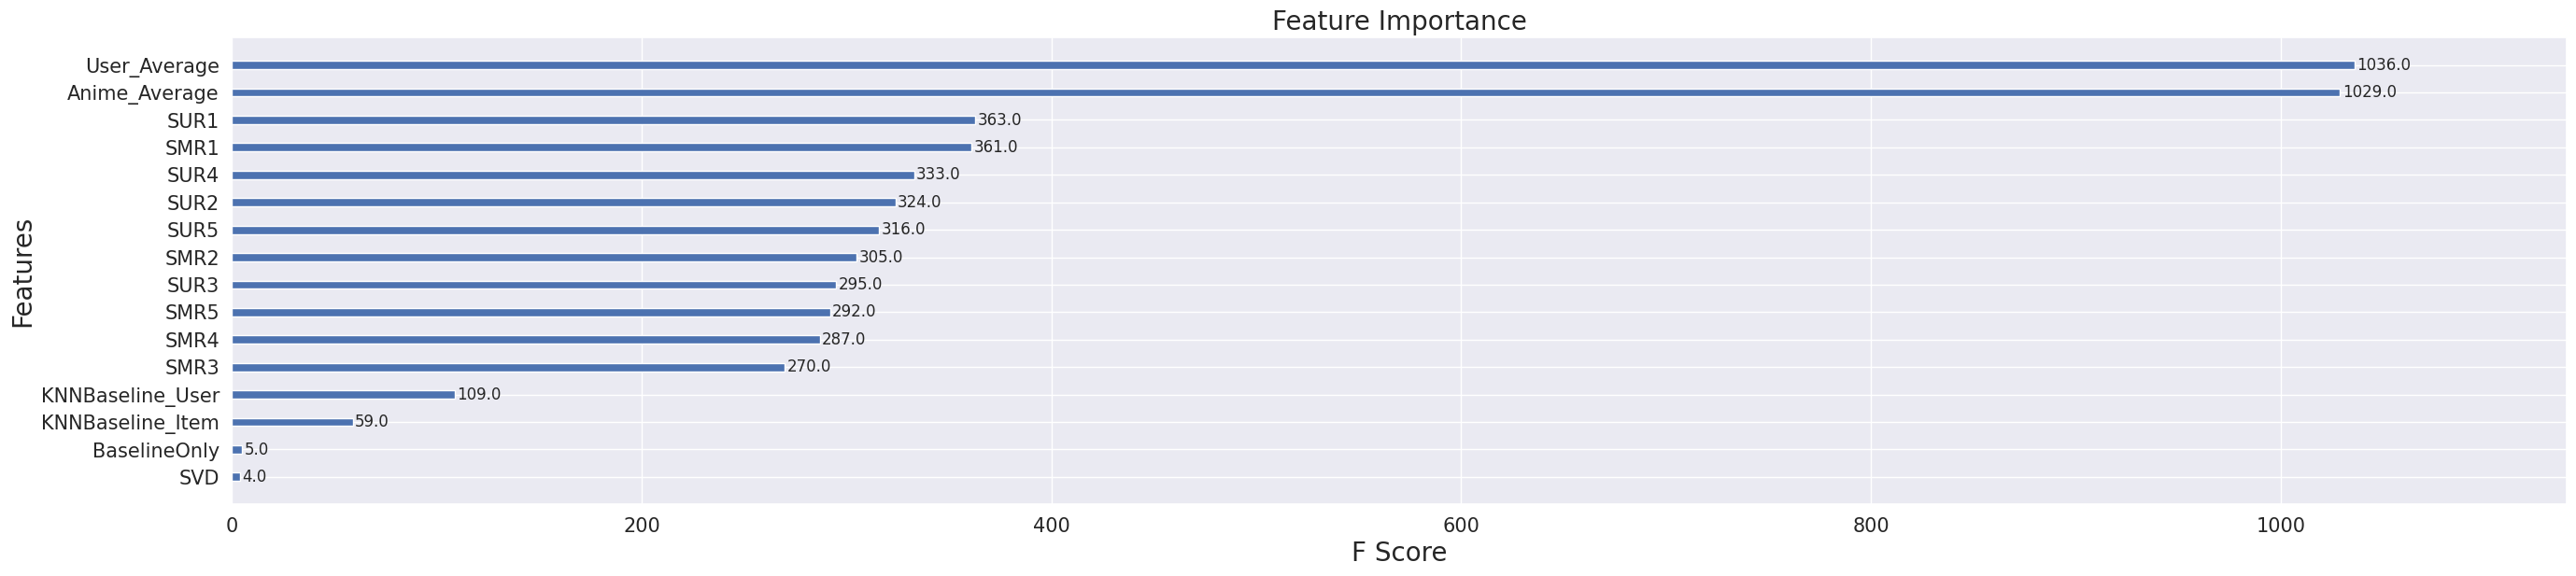

In [259]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Anime_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE : 1.3305614338353189
MAPE : 13.99288145942125
--------------------------------------------------
TEST DATA
RMSE : 1.522605316578542
MAPE : 18.07882876232705
--------------------------------------------------
Time Taken :  0:00:00.180746


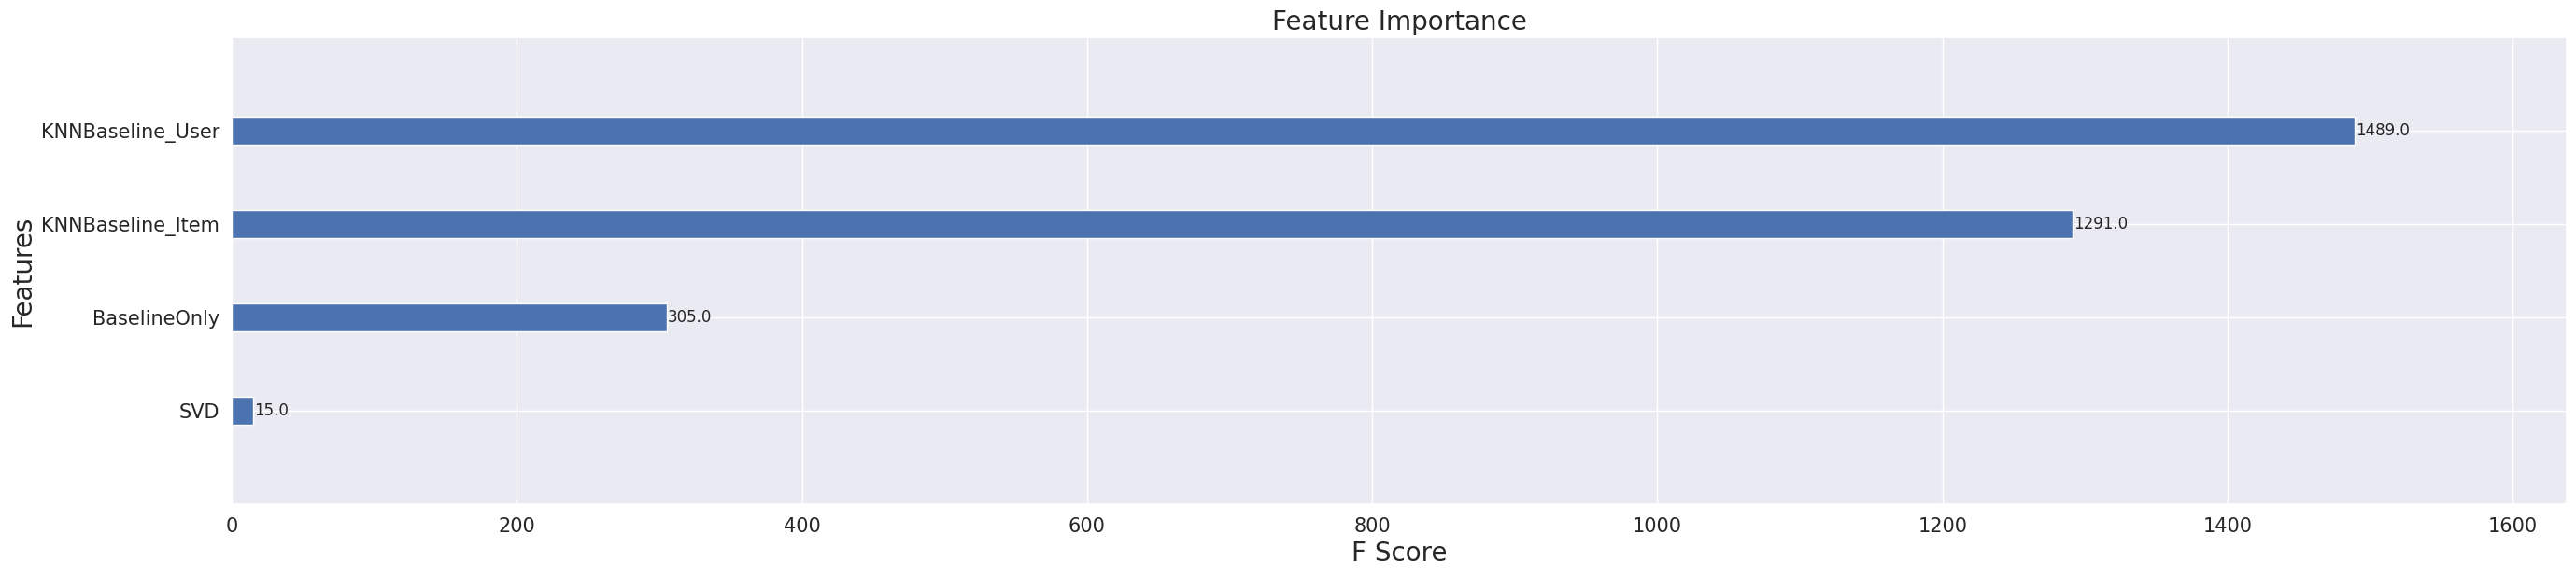

In [260]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

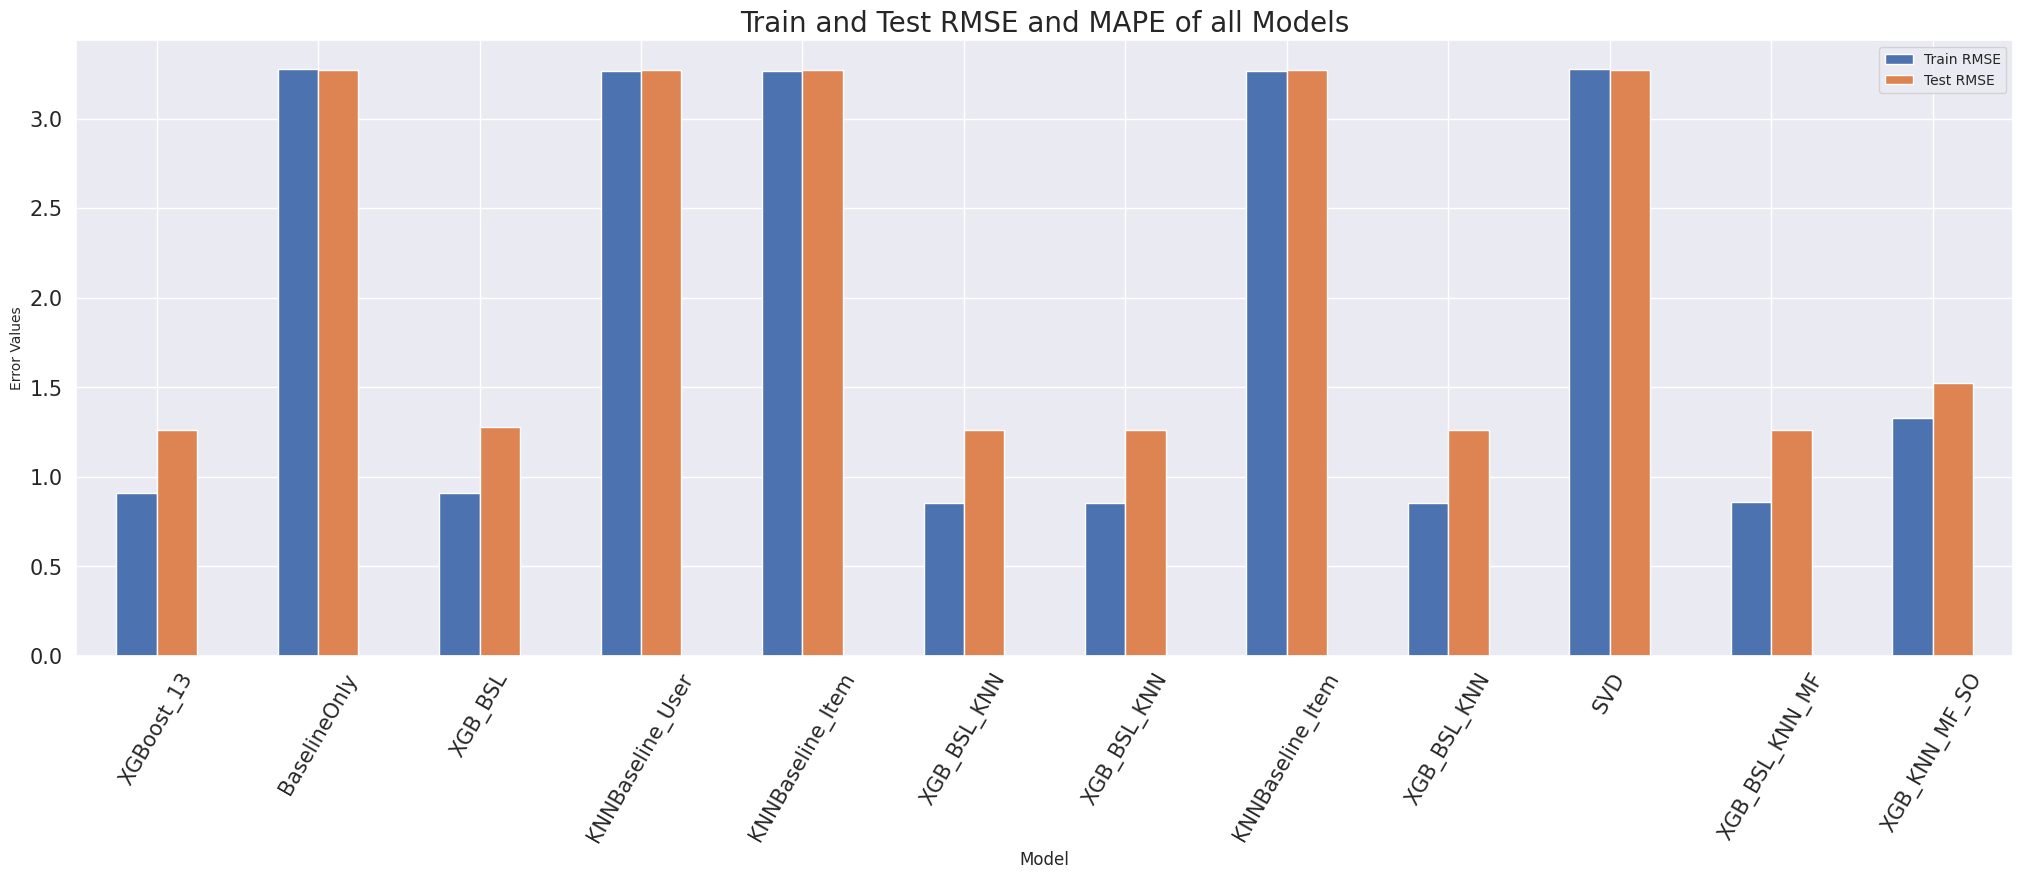

In [261]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

In [262]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.911661,1.263633
1,BaselineOnly,3.274317,3.269328
2,XGB_BSL,0.910940,1.275625
3,KNNBaseline_User,3.263818,3.273491
4,KNNBaseline_Item,3.264584,3.269160
5,XGB_BSL_KNN,0.856353,1.260080
6,XGB_BSL_KNN,0.856353,1.260080
7,KNNBaseline_Item,3.263424,3.269108
8,XGB_BSL_KNN,0.856353,1.260080
9,SVD,3.274656,3.269635


### **4.3 Generating Recommendation for Users**

We are using SVD to generate atmost 10 recommendated animes for various users.

In [263]:
from collections import defaultdict

def Get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, mid, true_r, est, _ in predictions:
        top_n[uid].append((mid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [264]:
svd = SVD(n_factors = 10, lr_all = 0.01, verbose=True)
svd.fit(trainset)
predictions = svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [265]:
# Saving the training predictions

train_pred = svd.test(trainset.build_anti_testset())
top_n = Get_top_n(train_pred, n=10)

In [292]:
def Generate_Recommendated_Animes(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["anime_id", "Predicted_Rating"])
    recommend = recommend.merge(df_filtered, how="inner", left_on="anime_id", right_on="anime_id")
    recommend = recommend.drop_duplicates(subset=["name"])
    recommend = recommend[["anime_id", "name", "genre", "Predicted_Rating"]]

    return recommend[:n]

In [293]:

sampled_user_id = list(top_n.keys())

In [296]:
test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Animes(test_id)

The user Id is :  52030


,anime_id,name,genre,Predicted_Rating
0,30,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",5
198,33,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...",5
281,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,"Action, Drama, Historical, Martial Arts, Roman...",5
339,563,DNA²,"Comedy, Romance, Sci-Fi",5
348,1016,Gunnm,"Drama, Mecha, Sci-Fi, Shounen",5
359,1065,Touch,"Drama, Romance, School, Shounen, Slice of Life...",5
364,1453,Maison Ikkoku,"Comedy, Drama, Romance, Slice of Life",5
370,2251,Baccano!,"Action, Comedy, Historical, Mystery, Seinen, S...",5
495,2924,ef: A Tale of Memories.,"Drama, Mystery, Romance",5
569,2986,Bamboo Blade,"Comedy, School, Seinen, Sports",5


## **5. Conclusion**

In this project, we learned the importance of Recommendation Systems, the types of recommender systems being implemented, and how to use matrix factorization to enhance a system.

We then built a movie recommendation system that considers user-user similarity, movie-movie similarity, global averages and matrix factorization. These concepts can be applied to any other user-item interactions systems.

We tried generating recommendations based on similarity matrix and Collaborative Filtering techniques.

We tried to predict the ratings for movies that the user might give based on its past rating behaviours and measure the accuracy using RMSE and MAPE error metrics.

Surely, there is huge scope of improvement and trying out different techniques and ML/DL algorithms.